In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
# Параметры отображения графиков:
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams.update({'font.size': 11})

# Считывание и предварительная обработка данных

In [5]:
# Словарь для преобразования текстовых названий месяцев в числовые:
months = {'Январь': '-01', 'Февраль': '-02', 'Март': '-03',
          'Апрель': '-04', 'Май': '-05', 'Июнь': '-06',
          'Июль': '-07', 'Август': '-08', 'Сентябрь': '-09',
          'Октябрь': '-10', 'Ноябрь': '-11', 'Декабрь': '-12'}

In [6]:
def string_to_date(date: str):
    """Функция преобразует строку формата 'дд Месяц гггг' в объект типа datetime.
    Аргументы:
        date - текстовая строка, содержащая день, месяц и год.
    Возвращает:
        Объект DateTime."""
    day, month, year = date.split()
    date = year + months[month] + '-' + day
    date = pd.to_datetime(date, errors='coerce')
    return date

In [7]:
# Путь к файлу с данными:
file_path = 'well_data.xlsx'

In [8]:
# Считывание данных по скважине из файла:
data = pd.read_excel(file_path, header=3)  # Заголовки в строке с инд. 3

In [9]:
# Исходные данные (ежедневные данные - в столбцах 1-31,
# среднемесячные данные в столбце - "Средн.", столбец "Дата"
# содержал объединенные ячейки, что привело к образованию пропусков):
data.head(10)

,Насос,Дата,Режимы,Unnamed: 3,Параметр,Средн.,1,2,3,4,...,22,23,24,25,26,27,28,29,30,31
0,"фонтанный лифт, глуб. 1021,67 м., МРП 7 д.,",Февраль 2020,NaN,NaN,Qж ТМ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,Qж,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,Обв ТМ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,Обв ХАЛ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,Обв,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,Пл. ж . ТМ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,Темп. ж. ТМ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,Qн ТМ,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,Qн,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,Нд,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Заполняем пропуски в объединенных ячейках с месяцем и годом, удаляем ненужные столбцы:
data['Дата'] = data['Дата'].fillna(method='ffill')
data.drop(['Режимы', 'Unnamed: 3', 'Насос', 'Средн.'], axis='columns', inplace=True)

In [11]:
# Выбираем строки, содержащие необходимые параметры:
data = data[data['Параметр'].isin(['Qн', 'Qж', 'Обв'])]  # Дебит нефти, дебит жидкости, обводненность.

In [12]:
# Преобразуем столбцы №1-31 в 2 столбца, содержащие № дня месяца и соотв. ему значение:
data = pd.melt(data, id_vars=['Дата', 'Параметр'], var_name='День', value_name='Значение')
data['Дата'] = data['День'].astype('str') + ' ' + data['Дата']  # 'дд Месяц гггг' в одной строке
data.drop('День', axis='columns', inplace=True)

In [13]:
# Преобразуем дату из строки в объект datetime:
data['Дата'] = data['Дата'].apply(string_to_date)
# Удаляем пропуски в столбце с датой (несуществующие дни месяца):
data.dropna(subset=['Дата'], inplace=True)

In [14]:
# Преобразуем значения параметров в числовой тип данных:
data['Значение'] = data['Значение'].apply(lambda x: np.nan if x == np.nan else str(x).replace(',', '.'))
data['Значение'] = pd.to_numeric(data['Значение'], errors='coerce')

In [15]:
# Делаем параметры заголовками столбцов, а даты - индексами строк:
data = data.pivot_table(index=['Дата'], columns='Параметр', values='Значение', dropna=False)
data.sort_index(inplace=True)  # Сортируем даты по возрастанию.

In [16]:
# Добавляем столбец с порядковым номером дня работы скважины:
data['Day'] = [i for i in range(1, len(data) + 1)]

In [17]:
# Добавляем столбец с дебитом воды:
data['Qв'] = data['Qж'] - data['Qн']

In [18]:
# Добавляем столбец с Water Oil Ratio:
data['WOR'] = data['Qв'] / data['Qн']

In [19]:
# Вид данных после предварительной обработки:
data.dropna().head()

Параметр,Qж,Qн,Обв,Day,Qв,WOR
Дата,,,,,,
2000-09-03,9.0,6.76,8.0,247,2.24,0.331361
2000-09-17,9.0,6.84,7.0,261,2.16,0.315789
2000-10-04,12.0,8.82,10.0,278,3.18,0.360544
2001-08-23,5.0,3.59,12.0,601,1.41,0.392758
2001-08-27,5.0,3.59,12.0,605,1.41,0.392758


In [20]:
# Количество пропусков по параметрам:
data.isna().sum()

Параметр
Qж     5655
Qн     5622
Обв    6165
Day       0
Qв     5655
WOR    5655
dtype: int64

In [21]:
# Количество строк и столбцов:
data.shape

(7365, 6)

# Визуализация данных

In [22]:
def simple_chart(df, par):
    """Функция выводит график с динамикой одного параметра по временной шкале.
    Аргументы:
        df - датафрейм с данными по скважине.
        par - наименования столбца (параметра)."""
    plt.scatter(df.index, df[par])
    plt.title(f'Динамика показателя {par}')
    plt.xticks(rotation=90)
    plt.tight_layout()

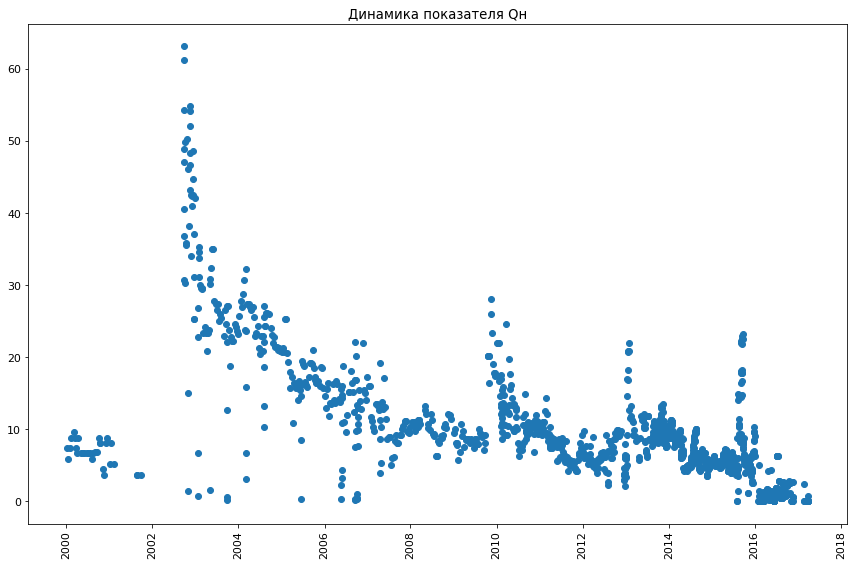

In [23]:
# График с динамикой дебита нефти:
simple_chart(data, 'Qн')

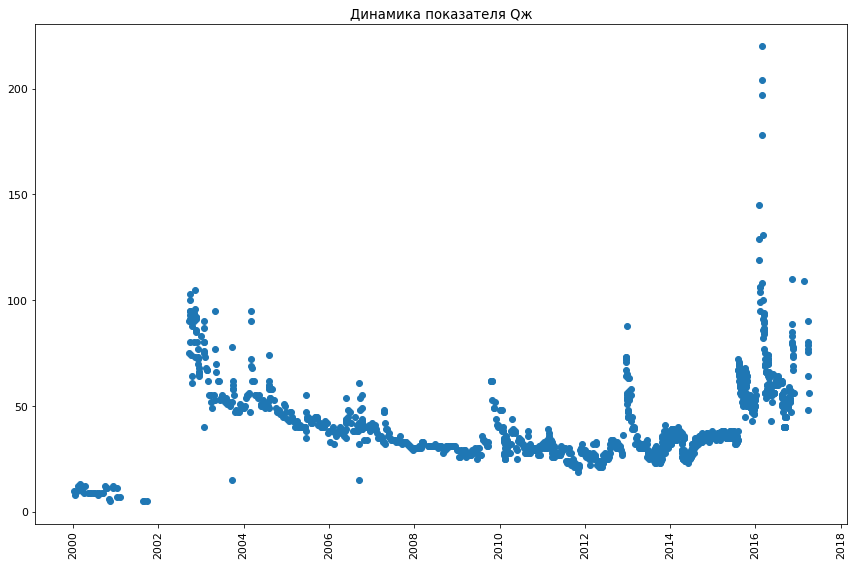

In [24]:
# График с динамикой дебита жидкости:
simple_chart(data, 'Qж')

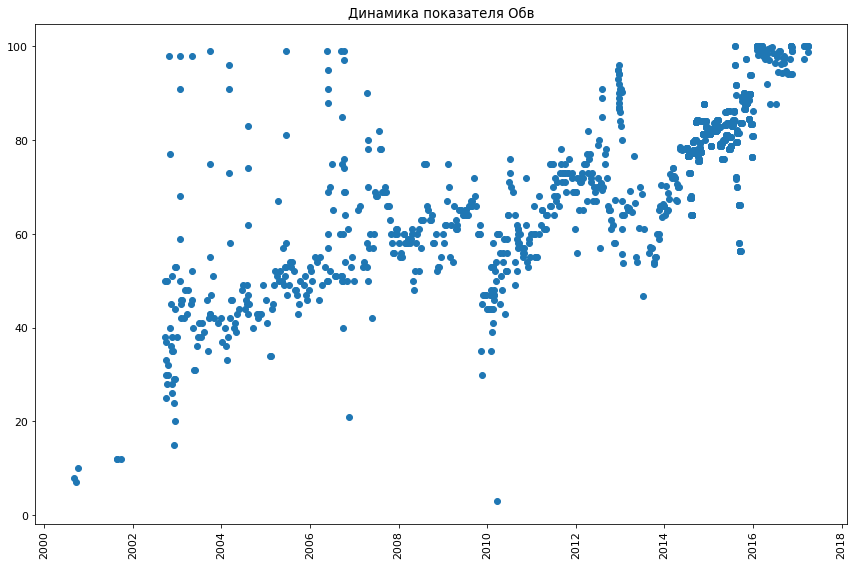

In [25]:
# График с динамикой обводненности:
simple_chart(data, 'Обв')

In [26]:
# Добавляем столбец с накопленным дебитом нефти:
data['Qн_cum'] = data['Qн'].cumsum()

In [27]:
# Считаем, что при обводненности 98% или WOR=49 скважина становится нерентабельной:
critical_WOR = 49

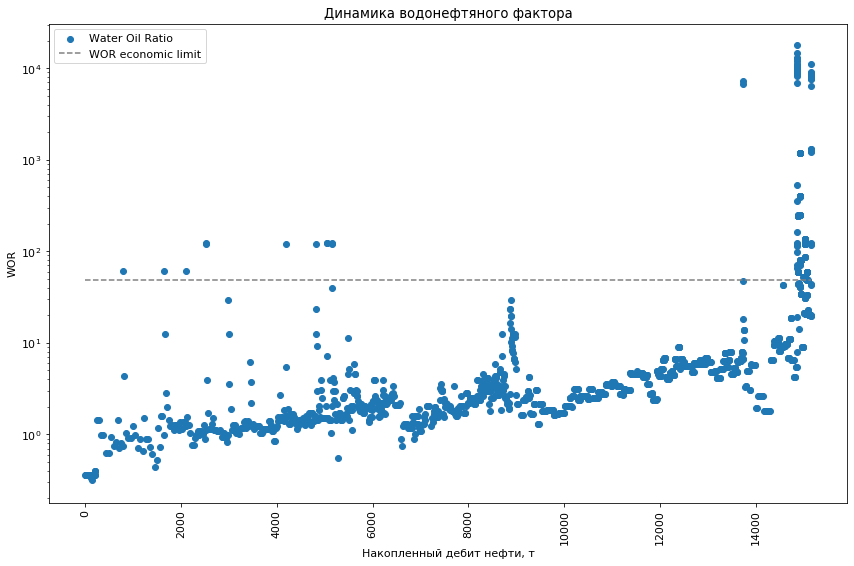

In [28]:
# Recovery plot (динамика нефтедобычи в пределах экономически эффективного WOR):
plt.scatter(data['Qн_cum'], data['WOR'], label='Water Oil Ratio')
plt.hlines(critical_WOR, 0, data['Qн_cum'].max(), colors='grey', linestyles='dashed', label='WOR economic limit')
plt.title(f'Динамика водонефтяного фактора')
plt.legend()
plt.xlabel('Накопленный дебит нефти, т')
plt.ylabel('WOR')
plt.yscale('log')
plt.xticks(rotation=90)
plt.tight_layout()

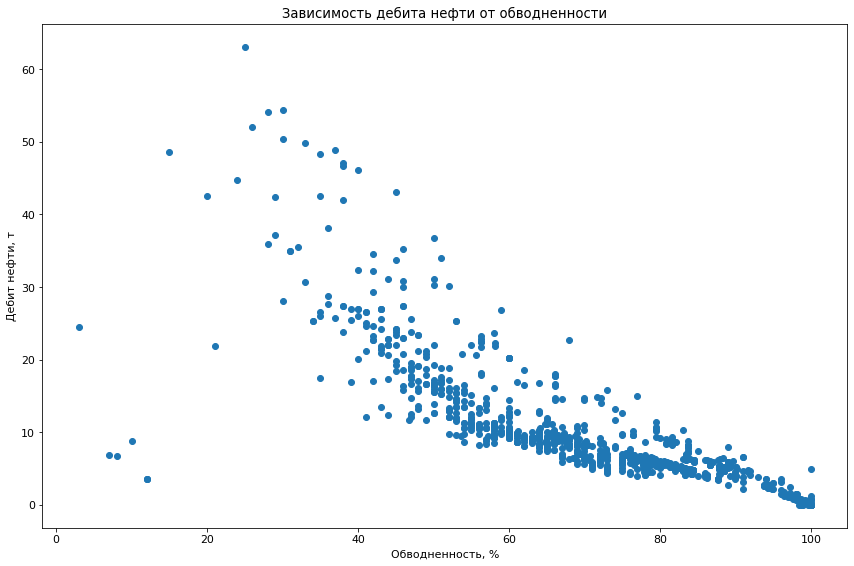

In [29]:
# Зависимость между параметрами 'Qн' и 'Обв':
plt.scatter(data['Обв'], data['Qн'])
plt.title('Зависимость дебита нефти от обводненности')
plt.xlabel('Обводненность, %')
plt.ylabel('Дебит нефти, т')
plt.tight_layout()

Text(0.5, 1, 'Матрица корреляции')

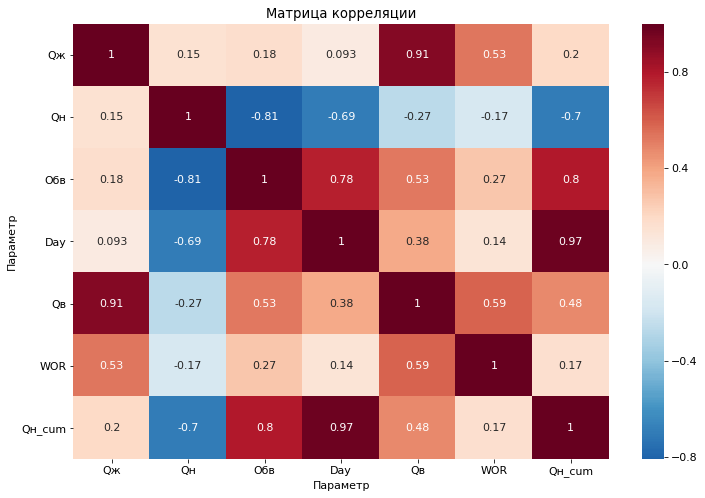

In [30]:
# Корреляция между параметрами:
correlation = data.corr()
ax = sns.heatmap(correlation, center=0, annot=True, cmap='RdBu_r')
l, r = ax.get_ylim()
ax.set_ylim(l + 0.5, r - 0.5)
plt.yticks(rotation=0)
plt.title('Матрица корреляции')

# Прогноз дебита нефти по гиперболической кривой падения

In [31]:
def hyperbolic_equation(t: float, qi: float, b: float, di: float):
    """Функция кривой гиперболического падения (Hyperbolic decline curve).
    Аргументы:
        t - время с начала работы скважины в днях.
        qi - максимум дебита в стартовый период работы скважины
             (или максимум более позднего периода для нетипичных скважин).
        b - константа гиперболического падения.
        di - номинальный уровень падения на шаге t=0.
    Возвращает:
        Ожидаемый уровень дебита на шаге t."""
    return qi / ((1.0 + b * di * t) ** (1.0 / b))

In [32]:
# Данные по дебиту нефти без пропусков:
oil_sequence = data[['Day', 'Qн']].dropna().copy()

In [33]:
# Числовой индекс пикового значения дебита нефти:
peak_index = np.argmax(oil_sequence['Qн'].values)

In [34]:
# Значение дебита нефти в этот день:
qi = oil_sequence.iloc[peak_index, :]['Qн']
qi

63.11

In [35]:
# Порядковый номер пикового дня:
peak_day = oil_sequence.iloc[peak_index, :]['Day']
peak_day

1001.0

In [36]:
# Усеченный временной ряд от найденного пика для подбора параметров уравнения:
oil_sequence = oil_sequence.iloc[peak_index:, :]

In [37]:
# Смещение относительно исходной шкалы для отсчета дней от единицы:
offset = oil_sequence['Day'].min() - 1

In [38]:
# Обновляем шкалу отсчета дней (дате пикового дебита соответствует значение 1):
oil_sequence['Day'] = oil_sequence['Day'] - offset

In [39]:
# Оптимальные параметры уравнения гиперболической кривой падения:
popt, pcov = curve_fit(hyperbolic_equation, oil_sequence['Day'], oil_sequence['Qн'], bounds=(0, [qi, 2, 20]))
qi, b, di = popt
print(f'Fit Curve Variables: qi={qi}, b={b}, di={di}')

Fit Curve Variables: qi=40.4868985886739, b=1.1855776230482225, di=0.001620313937378483


In [40]:
# Увеличиваем шкалу дней основного датафрейма на год:
pred_start = data['Day'].max() + 1
pred_end = pred_start + 365
data = data.append(pd.DataFrame({'Day': [i for i in range(pred_start, pred_end)]}), ignore_index=True, sort=False)

In [41]:
# Создаем вспомогательную шкалу для прогноза на год вперед:
days = np.array([i for i in range(1, pred_end - offset)])

In [42]:
# Добавляем прогноз дебита нефти в основной датафрейм:
data.loc[data['Day'] >= peak_day, 'Qн_pred'] = hyperbolic_equation(days, *popt)

In [43]:
# Доверительный интервал прогноза по параметрам уравнения:
sigma = np.sqrt(np.diag(pcov))
data.loc[data['Day'] >= peak_day, 'Qн_upper'] = hyperbolic_equation(days, qi + sigma[0], b, di)
data.loc[data['Day'] >= peak_day, 'Qн_lower'] = hyperbolic_equation(days, qi - sigma[0], b, di)

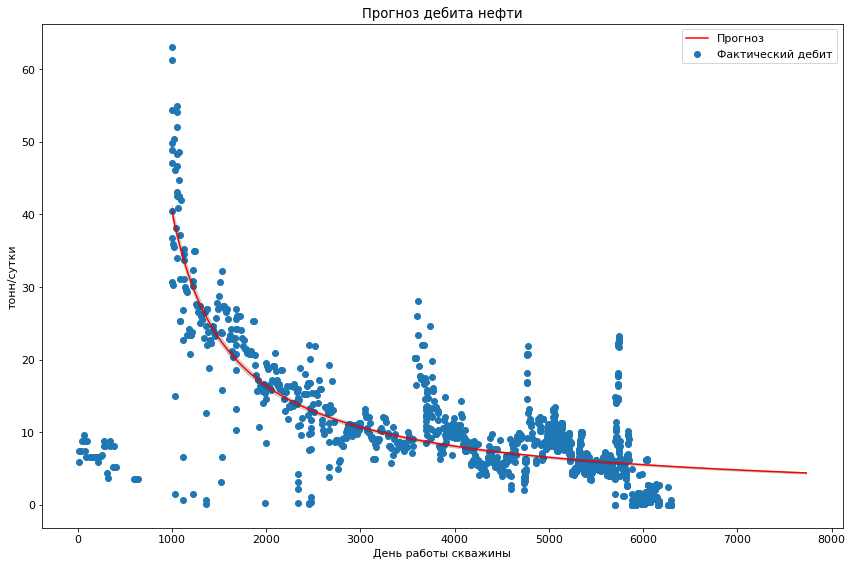

In [44]:
# График с динамикой и прогнозом дебита нефти:
plt.scatter(data['Day'], data['Qн'], label='Фактический дебит')
plt.plot(data['Day'], data['Qн_pred'], color='red', label='Прогноз')
plt.fill_between(data['Day'], data['Qн_upper'], data['Qн_lower'], color='black', alpha=0.15)
plt.title('Прогноз дебита нефти')
plt.xlabel('День работы скважины')
plt.ylabel('тонн/сутки')
plt.legend()
plt.tight_layout()

# Прогноз обводненности по экспоненциальной кривой роста

In [45]:
def exp_equation(t: float, wpc: float):
    """Функция кривой экспоненциального роста обводненности.
    Аргументы:
        t - время с начала работы скважины в днях.
        wpc - минимум обводненности в стартовый период работы скважины
             (или минимум более позднего периода для нетипичных скважин).
    Output:
        Возвращает ожидаемый уровень обводненности на шаге t."""
    return (t / (t + wpc)) * 100

In [46]:
# Данные по обводненности без пропусков:
wpc_sequence = data[['Day', 'Обв']].dropna().copy()

In [47]:
# Числовой индекс минимального значения обводненности:
min_index = np.argmin(wpc_sequence['Обв'].values)

In [48]:
# Значение обводненности в этот день:
wpc = wpc_sequence.iloc[min_index, :]['Обв']
wpc

3.0

In [49]:
# Порядковый номер дня с минимальной обводненностью:
min_day = wpc_sequence.iloc[min_index, :]['Day']
min_day

3736.0

In [50]:
# Усеченный временной ряд от найденного минимума для подбора параметров уравнения:
wpc_sequence = wpc_sequence.iloc[min_index:, :]

In [51]:
# Смещение относительно исходной шкалы для отсчета дней от единицы:
offset = wpc_sequence['Day'].min() - 1

In [52]:
# Обновляем шкалу отсчета дней (дате минимума соответствует значение 1):
wpc_sequence['Day'] = wpc_sequence['Day'] - offset

In [53]:
# Оптимальные параметры уравнения гиперболической кривой падения:
popt, pcov = curve_fit(exp_equation, wpc_sequence['Day'], wpc_sequence['Обв'], bounds=(wpc, np.inf))
wpc = popt[0]
print(f'Fit Curve Variables: wpc={wpc}')

Fit Curve Variables: wpc=311.7908869916465


In [54]:
# Обновляем значения вспомогательной шкалы для прогноза на год вперед:
days = np.array([i for i in range(1, pred_end - offset)])

In [55]:
# Добавляем прогноз обводненности в основной датафрейм:
data.loc[data['Day'] >= min_day, 'Обв_pred'] = exp_equation(days, *popt)

In [56]:
# Доверительный интервал прогноза по параметрам уравнения:
sigma = np.sqrt(np.diag(pcov))
data.loc[data['Day'] >= min_day, 'Обв_upper'] = exp_equation(days, *(popt + 2 * sigma))
data.loc[data['Day'] >= min_day, 'Обв_lower'] = exp_equation(days, *(popt - 2 * sigma))

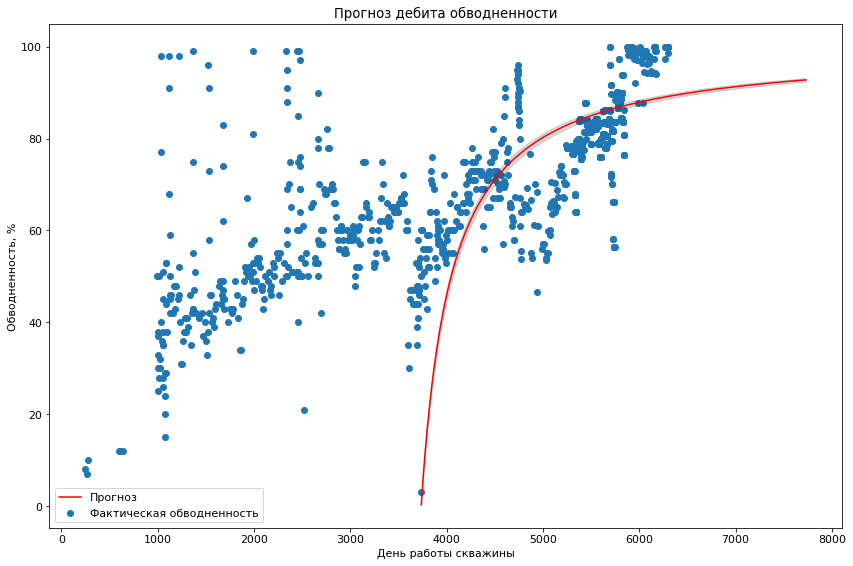

In [57]:
# График с динамикой и прогнозом обводненности:
plt.scatter(data['Day'], data['Обв'], label='Фактическая обводненность')
plt.plot(data['Day'], data['Обв_pred'], color='red', label='Прогноз')
plt.fill_between(data['Day'], data['Обв_upper'], data['Обв_lower'], color='black', alpha=0.15)
plt.title('Прогноз дебита обводненности')
plt.xlabel('День работы скважины')
plt.ylabel('Обводненность, %')
plt.legend()
plt.tight_layout()